In [30]:
import os
# os.chdir('../')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/viz_utils.py'>

# Training separate α/β classifiers

In [31]:
data_beta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=True, 
                     use_standardization=True)
X_train, y_train, X_test, y_test = split_data_by_batch(data=data_beta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')
best_clfs_beta = evaluate_models(X_train, y_train, X_test, y_test, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'linear', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.88

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 100, 'model__weights': 'distance'}
Test f1-score for the best model 0.66

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 50, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Test f1-score

In [32]:
data_alpha = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True)
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data_by_batch(data=data_alpha, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')

best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, 
                                  X_test_alpha, y_test_alpha, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.74

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.73

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}
Test f1-score for the best model 0.69

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 75, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Test f1-score

# Training joint αβ classifier

In [33]:
data_alpha_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=False,
                     make_all_features_bool=True,
                     use_standardization=True)
print('alpha ready')
data_beta_for_joint = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/desc_fmba_not_nan_hla.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=True, 
                     use_standardization=True)
data_joint = pd.concat([data_beta_for_joint[[x for x in data_beta_for_joint.columns if x.startswith('CAS')]], data_alpha_for_joint], axis=1)


X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data_by_batch(data=data_joint, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')

best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

alpha ready
Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'linear', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.86

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.64

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.54

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 50, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Tes

# Training classifiers based on metaclones

In [34]:
data_beta_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/desc_fmba_new_split.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRB_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True)

data_alpha_meta = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/desc_fmba_new_split.csv',
                     clonotype_matrix_path='data/clone_matrix_covid_fmba_TRA_metaclone.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True,
                     use_hla_clones=False,
                     use_hla_bool=True,
                     make_all_features_bool=True,
                     use_standardization=True)

data_beta_meta = data_beta_meta.rename(columns={f'cluster_{x}': f'b_cluster_{x}' for x in range(23)})
data_alpha_meta = data_alpha_meta.rename(columns={f'cluster_{x}': f'a_cluster_{x}' for x in range(140)})
data_joint_meta = pd.concat([data_beta_meta[[x for x in data_beta_meta.columns if x.startswith('b')]], data_alpha_meta], axis=1)

In [35]:
X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m = split_data_by_batch(data=data_beta_meta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')
X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m = split_data_by_batch(data=data_alpha_meta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')
X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m = split_data_by_batch(data=data_joint_meta, 
                                                       test_batches=['2020/10_FMBA_NovaSeq6'], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [36]:
X_test

,CAHSRGYEQYF,CAISEGTSGSYEQYF,CAISGQGVNTEAFF,CAISLGGNQPQHF,CAISRGYEQYF,CANSLGGSYEQYF,CASAPGGSYEQYF,CASARGYEQYF,CASDRGYEQYF,CASGDSSYEQYF,...,DRB1*08,DRB1*03,DRB1*15,DRB1*13,DRB1*04,DRB1*09,DRB1*10,DRB1*14,DRB1*12,DRB1*16
16,1.244182,-0.213402,-0.220997,0.143910,0.875725,-0.476663,-0.365690,0.556441,0.516331,-0.509343,...,False,False,True,False,False,False,False,False,False,False
144,-0.366938,-0.213402,-0.220997,-0.627608,-0.421367,-0.476663,-0.365690,-0.490577,-0.466349,-0.509343,...,False,True,True,False,False,False,False,False,False,False
145,-0.366938,-0.213402,-0.220997,0.628793,-0.421367,-0.476663,0.751644,0.361945,0.333787,0.211042,...,False,False,False,False,True,False,False,False,False,False
146,-0.366938,-0.213402,3.051697,0.160396,-0.421367,0.729722,2.437442,-0.490577,-0.466349,0.394296,...,False,False,False,False,False,False,False,False,False,False
148,-0.366938,1.685607,-0.220997,-0.627608,-0.421367,-0.476663,1.312992,0.790252,0.735775,-0.509343,...,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,-0.366938,-0.213402,-0.220997,0.529834,-0.421367,-0.476663,-0.365690,-0.490577,-0.466349,-0.509343,...,False,False,False,False,True,False,False,True,False,False
919,2.618378,-0.213402,-0.220997,-0.627608,4.385513,-0.476663,-0.365690,1.449489,1.354503,-0.509343,...,False,False,False,False,True,False,False,False,False,False
920,-0.366938,-0.213402,-0.220997,0.189677,-0.421367,-0.476663,-0.365690,-0.490577,-0.466349,-0.509343,...,False,False,False,True,True,False,False,False,False,False
921,-0.366938,-0.213402,-0.220997,-0.627608,-0.421367,-0.476663,-0.365690,-0.490577,-0.466349,0.908134,...,False,False,False,True,False,False,False,False,False,False


In [37]:
best_clfs_beta_m = evaluate_models(X_train_beta_m, y_train_beta_m, X_test_beta_m, y_test_beta_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_alpha_m = evaluate_models(X_train_alpha_m, y_train_alpha_m, X_test_alpha_m, y_test_alpha_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

best_clfs_joint_m = evaluate_models(X_train_joint_m, y_train_joint_m, X_test_joint_m, y_test_joint_m, 
                                  get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 1, 'model__kernel': 'sigmoid', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.84

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.74

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.53

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Test f1-score f

/home/ekvlasova/.conda-envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ekvlasova/.conda-envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ekvlasova/.conda-envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ekvlasova/.conda-envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params for mlpclassifier: {'model__alpha': 1e-05, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}
Test f1-score for the best model 0.87

Started evaluating xgboost
Best params for xgboost: {'model__n_estimators': 50, 'model__random_state': 42, 'model__subsample': 0.75}
Test f1-score for the best model 0.68

classifier       svm        ab       knn       rfc  mlpclassifier   xgboost
f1-score    0.886792  0.733945  0.545455  0.654088       0.873786  0.677419
Best model is svm with params: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}


In [38]:
best_clfs_joint_m = (best_clfs_joint_m[0], best_clfs_joint_m[1], 'svm')

In [39]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint,
     'beta_meta': best_clfs_beta_m,
     'alpha_meta': best_clfs_alpha_m,
     'joint_meta': best_clfs_joint_m,
}
X_test_data={
     'beta': X_test,
     'alpha': X_test_alpha,
     'joint': X_test_joint,
     'beta_meta': X_test_beta_m,
     'alpha_meta': X_test_alpha_m,
     'joint_meta': X_test_joint_m,
}
y_test_data={
     'beta': y_test,
     'alpha': y_test_alpha,
     'joint': y_test_joint,
     'beta_meta': y_test_beta_m,
     'alpha_meta': y_test_alpha_m,
     'joint_meta': y_test_joint_m,
}
X_train_data={
     'beta': X_train,
     'alpha': X_train_alpha,
     'joint': X_train_joint,
     'beta_meta': X_train_beta_m,
     'alpha_meta': X_train_alpha_m,
     'joint_meta': X_train_joint_m,
}
y_train_data={
     'beta': y_train,
     'alpha': y_train_alpha,
     'joint': y_train_joint,
     'beta_meta': y_train_beta_m,
     'alpha_meta': y_train_alpha_m,
     'joint_meta': y_train_joint_m,
}

In [40]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['beta','alpha','joint','beta_meta','alpha_meta','joint_meta']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

In [41]:
comparison_df

,model,f1,data_type
0,svm,0.879310,beta
1,ab,0.693548,beta
2,knn,0.659794,beta
3,rfc,0.627219,beta
4,mlpclassifier,0.852174,beta
5,xgboost,0.634483,beta
6,svm,0.741379,alpha
7,ab,0.728814,alpha
8,knn,0.689076,alpha
9,rfc,0.645963,alpha


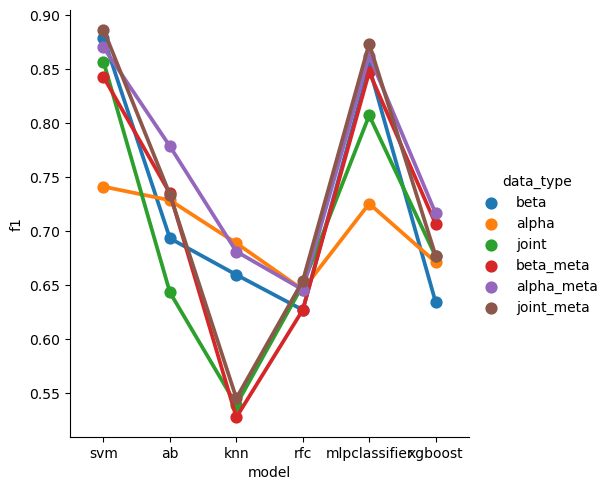

In [42]:
fig, ax = plt.subplots()
sns.catplot(data=comparison_df, x="model", y="f1", hue="data_type", kind="point", ax=ax)
plt.close(1)

<AxesSubplot:xlabel='model', ylabel='f1'>

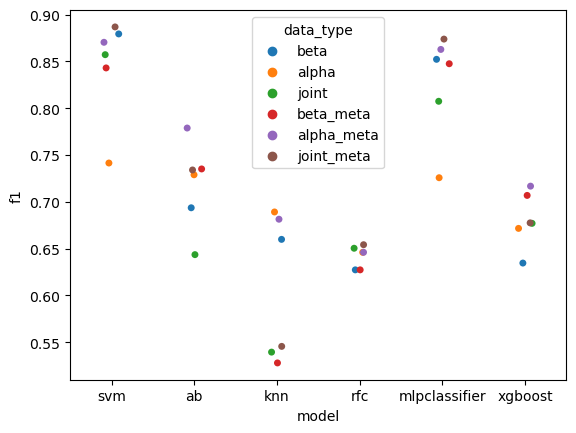

In [43]:
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type",)

In [44]:
all_clfs['joint']

({'svm': Pipeline(steps=[('model',
                   SVC(C=1, kernel='linear', probability=True, random_state=42))]),
  'ab': Pipeline(steps=[('model',
                   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                      n_estimators=150, random_state=42))]),
  'knn': Pipeline(steps=[('model', KNeighborsClassifier(leaf_size=1, n_neighbors=3))]),
  'rfc': Pipeline(steps=[('model',
                   RandomForestClassifier(max_depth=3, min_samples_leaf=10,
                                          n_estimators=50, random_state=42))]),
  'mlpclassifier': Pipeline(steps=[('model',
                   MLPClassifier(hidden_layer_sizes=(100, 50, 25, 10),
                                 max_iter=1000, random_state=42))]),
  'xgboost': Pipeline(steps=[('model',
                   XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                                 colsample_bylevel=1, colsample_bynode=1,
                    

# Making metrics dataframe

In [45]:
clf_name = []
clf_type = []
f1 = []
precision = []
recall = []
for key, clfs in all_clfs.items():
    clf_name.append(key)
    clf_type.append(clfs[2])
    best_clf = clfs[0]['svm']
    clf_predictions = best_clf.predict(X_test_data[key])
    f1.append(f1_score(y_test_data[key], clf_predictions))
    precision.append(precision_score(y_test_data[key], clf_predictions))
    recall.append(recall_score(y_test_data[key], clf_predictions))

In [46]:
plotting_df = pd.DataFrame({
    'classifier': clf_name, 
    'best_classifier_predictor': clf_type,
    'f1_score': f1,
    'precision_score': precision,
    'recall_score': recall
})

In [47]:
plotting_df

,classifier,best_classifier_predictor,f1_score,precision_score,recall_score
0,beta,svm,0.879310,0.809524,0.962264
1,alpha,svm,0.741379,0.682540,0.811321
2,joint,svm,0.857143,0.865385,0.849057
3,beta_meta,mlpclassifier,0.842975,0.750000,0.962264
4,alpha_meta,svm,0.870370,0.854545,0.886792
5,joint_meta,svm,0.886792,0.886792,0.886792


In [48]:
plotting_df = plotting_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

# Preparing data for proba comparison

In [49]:
beta_predictions = all_clfs['beta'][0]['svm'].predict_proba(X_test_data['beta'])[::,1]
alpha_predictions = all_clfs['alpha'][0]['svm'].predict_proba(X_test_data['alpha'])[::,1]
beta_meta_predictions = all_clfs['beta_meta'][0]['svm'].predict_proba(X_test_data['beta_meta'])[::,1]
alpha_meta_predictions = all_clfs['alpha_meta'][0]['svm'].predict_proba(X_test_data['alpha_meta'])[::,1]
joint_predictions = all_clfs['joint'][0]['svm'].predict_proba(X_test_data['joint'])[::,1]
joint_meta_predictions = all_clfs['joint_meta'][0]['svm'].predict_proba(X_test_data['joint_meta'])[::,1]

proba_labels = y_test.apply(lambda x: 'healthy' if x == 0 else 'covid')
probability_df = pd.DataFrame({
    'beta_proba': beta_predictions,
    'alpha_proba': alpha_predictions,
    'beta_meta_proba': beta_meta_predictions,
    'alpha_meta_proba': alpha_meta_predictions,
    'joint_proba': joint_predictions,
    'joint_meta_proba': joint_meta_predictions,
    'covid': proba_labels
})

In [50]:
probability_df

,beta_proba,alpha_proba,beta_meta_proba,alpha_meta_proba,joint_proba,joint_meta_proba,covid
16,1.000000,0.987957,1.000000,0.906543,0.999985,0.813768,covid
144,0.969421,0.015977,0.986796,0.205477,0.171729,0.086449,covid
145,0.989920,0.328422,0.999997,0.643038,0.676882,0.482321,covid
146,0.739438,0.762860,0.906016,0.991480,0.771351,0.996458,covid
148,0.593587,0.751538,0.871905,0.904189,0.716091,0.903175,covid
...,...,...,...,...,...,...,...
909,0.428154,0.163812,0.586560,0.048069,0.090611,0.007002,healthy
919,0.572725,0.577416,0.296294,0.377619,0.367023,0.153163,healthy
920,0.583774,0.194742,0.232534,0.034236,0.157080,0.185117,healthy
921,0.057983,0.348177,0.018311,0.007436,0.257415,0.010986,healthy


# One folder out CV

In [51]:
metrics_df = []
for metrics, metrics_name in zip([f1_score, precision_score, recall_score], ['f1', 'precision', 'recall']):
    metrics_df.append(cross_validation_between_batches(best_clfs_joint_m[0]['svm'], 
                                 data_joint_meta, 
                                 [x for x in data_joint_meta.folder.unique()], 
                                 y_column='covid', 
                                 batch_column='folder', 
                                 metrics=metrics, 
                                 metrics_name=metrics_name, 
                                 return_metrics_results=True,
                                 ))

In [52]:
metrics_df = metrics_df[0].merge(metrics_df[1]).merge(metrics_df[2])
metrics_df

,folder,f1,precision,recall
0,2020/10_FMBA_NovaSeq5,0.879433,0.815789,0.953846
1,NovaSeq14,0.941667,0.926230,0.957627
2,2020/12_FMBA_Novaseq8_DNA,0.948148,0.907801,0.992248
3,2020/10_FMBA_NovaSeq6,0.886792,0.886792,0.886792
4,2020/12_FMBA_Novaseq7_DNA,0.945455,0.904348,0.990476
5,NovaSeq24,0.969072,0.959184,0.979167
6,NovaSeq34,0.968750,0.958763,0.978947


# Feature importances analysis

In [53]:
data = {'feature_names': X_train_data['joint_meta'].columns}
for mdl in ['ab', 'xgboost', 'rfc']:
    data[mdl] = best_clfs_joint_m[0][mdl]['model'].feature_importances_
fi_df = pd.DataFrame(data)

# Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['xgboost'], ascending=False, inplace=True)
fi_df = fi_df.head(40)
fi_df = fi_df.reset_index(drop=True)

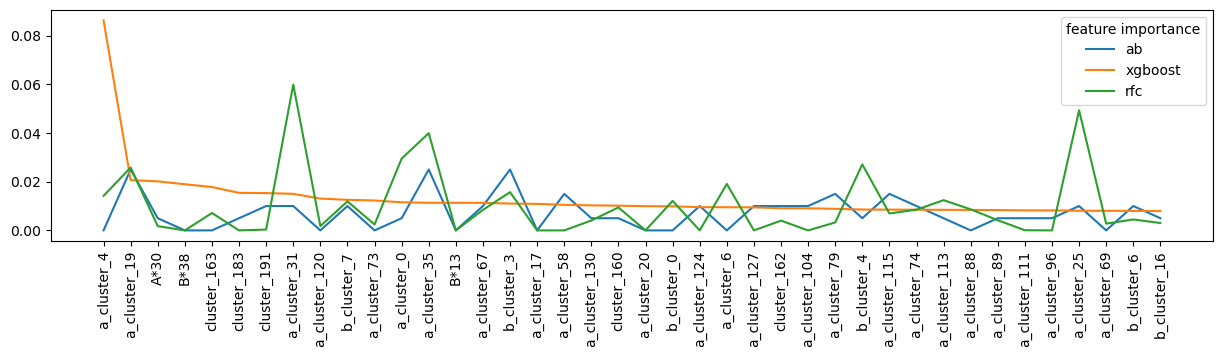

In [54]:
fig, ax = plt.subplots(figsize=(15, 3))
for mdl in ['ab', 'xgboost', 'rfc']:
    ax.plot(fi_df.index, fi_df[mdl], label=mdl)
ax.set_xticks(ticks=range(len(fi_df.index)),
              labels=fi_df.feature_names,
              rotation=90)
ax.legend(title='feature importance')

# Plotting

In [55]:
for key in all_clfs:
    all_clfs[key][0][all_clfs[key][2]].fit(X_train_data[key], y_train_data[key])

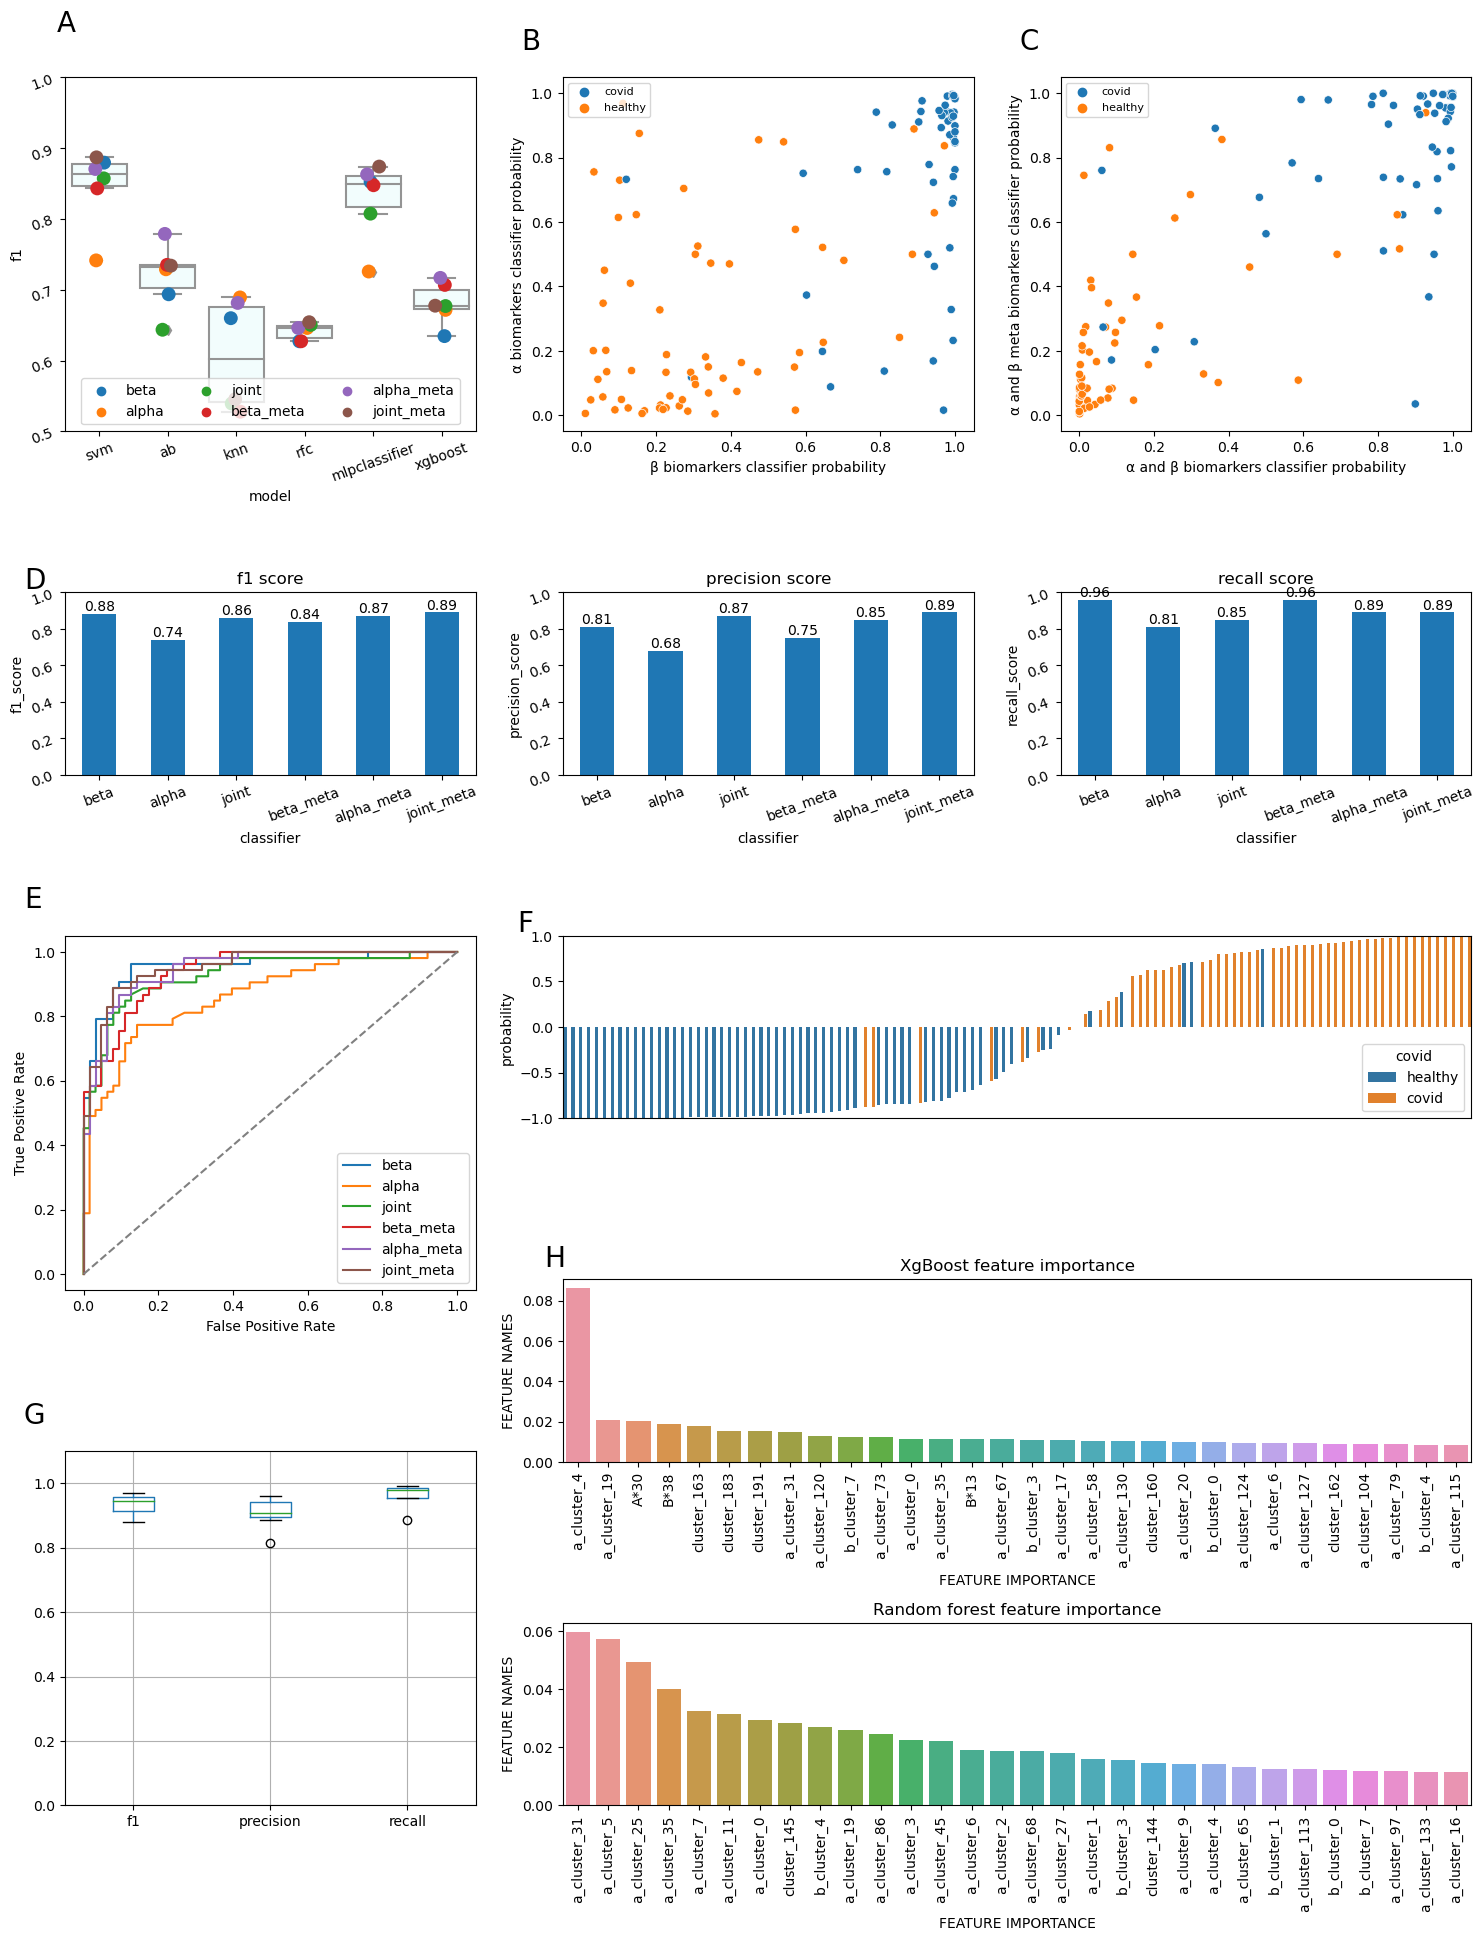

In [56]:
fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=12, 
              ncols=3)
font_size=20
delta_x=-0.1
delta_y=1.14


########################################################

for i, (letter, metrics) in enumerate(zip(['D', None, None], ['f1_score', 'precision_score', 'recall_score'])):
    
    ax = fig.add_subplot(gs[3:5, i])
    plotting_df[['classifier', metrics]].set_index('classifier').plot(kind='bar', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.tick_params(labelrotation=20)
    ax.get_legend().remove()
    ax.set_ylabel(metrics)
    ax.set_title(f"{metrics.replace('_', ' ')}")
    ax.tick_params(labelrotation=20)
    ax.set_ylim(0, 1)
    if letter is not None:
        ax.text(delta_x, delta_y, letter,
             horizontalalignment='left',
             verticalalignment='top',
            transform=ax.transAxes,
                size=font_size)

########################################################
ax3 = fig.add_subplot(gs[5:8, 0])

for key in all_clfs:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key][0][all_clfs[key][2]].predict_proba(X_test_data[key])[::,1])
    ax3.plot(fpr,tpr, label=key)

ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax3.legend()
# ax3.set_title('ROC-curve')
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

########################################################

ax4 = fig.add_subplot(gs[:3, 1])
sns.scatterplot(data=probability_df, x='beta_proba', y='alpha_proba', hue='covid')
ax4.legend(fontsize="8", loc ="upper left")
ax4.set_ylim(-0.05, 1.05)
ax4.set_xlim(-0.05, 1.05)
# ax4.set_title('Probability of COVID-19+ for α vs β biomarkers')
ax4.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)
ax4.set_xlabel('β biomarkers classifier probability')
ax4.set_ylabel('α biomarkers classifier probability')

########################################################

ax5 = fig.add_subplot(gs[:3, 2])
sns.scatterplot(data=probability_df, x='joint_meta_proba', y='joint_proba', hue='covid')
ax5.legend(fontsize="8", loc ="upper left")
ax5.set_ylim(-0.05, 1.05)
ax5.set_xlim(-0.05, 1.05)
# ax5.set_title('Probability of COVID-19+ for α and β biomarkers vs meta biomarkers')
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.set_xlabel('α and β biomarkers classifier probability')
ax5.set_ylabel('α and β meta biomarkers classifier probability')


########################################################

ax6 = fig.add_subplot(gs[5:7, 1:])
plot_waterfall_by_column(probability_df, proba_column='joint_meta_proba', label_column='covid', ax=ax6)
# ax6.set_title('Waterfall plot for α+β metaclone classifier')
ax6.text(delta_x+0.05, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.tick_params(bottom=False)
ax6.set_ylim(-1, 1)

########################################################
ax7 = fig.add_subplot(gs[8:11, 0])

metrics_df.boxplot(ax=ax7)
# ax7.set_title('Scores across batches for α+β metaclone classifier')
ax7.set_ylim(0.5, 1.1)
ax7.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)
########################################################

ax8 = fig.add_subplot(gs[7:9, 1:])
plot_feature_importances(best_clfs_joint_m[0]['xgboost']['model'],
                         feature_names=X_train_data['joint_meta'].columns, 
                         model_type='xgboost', 
                         k_best=50,
                         ax=ax8)
# for mdl in ['ab', 'xgboost', 'rfc']:
#     ax8.plot(fi_df.index, fi_df[mdl], label=mdl)
# ax8.set_xticks(ticks=range(len(fi_df.index)),
#               labels=fi_df.feature_names,
#               rotation=90)
ax8.text(delta_x+0.08, delta_y+0.05, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax8.transAxes,
        size=font_size)
ax8.set_title('XgBoost feature importance')
########################################################

ax10 = fig.add_subplot(gs[9:11, 1:])
plot_feature_importances(best_clfs_joint_m[0]['rfc']['model'],
                         feature_names=X_train_data['joint_meta'].columns, 
                         model_type='rfc', 
                         k_best=30,
                         ax=ax10)
ax10.set_title('Random forest feature importance')

########################################################

ax9 = fig.add_subplot(gs[:3, 0])
sns.stripplot(data=comparison_df, x="model", y="f1", hue="data_type", ax=ax9, s=10)
sns.boxplot(data=comparison_df, x="model", y="f1", ax=ax9, color='azure')
ax9.text(delta_x+0.08, delta_y+0.05, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax9.transAxes,
        size=font_size)
# ax9.set_title('Comparison of f1-score across models')
ax9.tick_params(labelrotation=20)
ax9.set_ylim(0.5, 1)
ax9.legend(ncol=3,  loc='upper center')

########################################################

plt.tight_layout()
plt.savefig("figures/fig4.svg")
plt.savefig("figures/fig4.pdf")
plt.savefig("figures/fig4.png")
plt.show()


Figure 4. Analysis of machine learning approaches applied to FMBA TCRβ and TCRα biomarkers. 

A, B, C. Distribution of target metrics (f1-score, precision, recall) for all the evaluated models.

D. ROC-curve plot for all the evaluated models.

E. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for TRCα and TCRβ based classifiers.

F. The sctterplot describing the relation of the probabilities to label the sample as the COVID-19 positive for classifier based on both TRCα,TCRβ biomarkers and TRCα,TCRβ metaclone cluster features.

G. The waterfall plot representing the probability of each sample to be labeld as COVID-19 positiove (> 0) or healthy (< 0). Samples coming from healthy donors are colored with blue, COVID-19 samples are colored with orange.

H. Evaluation of target metrics (f1-score, precision, recall) for one batch out cross validation.

I. Feature importance plot for the XGBoost classifier based on TRCα and TCRβ based biomarkers and HLA presence features.